In [1]:
!git clone https://github.com/KORALLLL/diffusion.git
!pip install torcheval

Cloning into 'diffusion'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 226 (delta 121), reused 170 (delta 69), pack-reused 0 (from 0)
Receiving objects: 100% (226/226), 2.40 MiB | 23.60 MiB/s, done.
Resolving deltas: 100% (121/121), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import pickle, gzip, math, os,sys, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from fastcore.test import test_close
import logging



sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('/kaggle/working/diffusion'))


from diffusion.data_utils import *
from diffusion.learners import *
from diffusion.callbacks import *
from diffusion.metrics import *
from diffusion.utils import *
from diffusion.modules import *

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

set_seed(42)

In [4]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[x] = [(TF.to_tensor(o)-xmean) / xstd for o in b[x]]
    
bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
act_gr  = partial(GeneralRelu, leak=0.1, sub=0.4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

# Going deeper

In [7]:
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128), norm=nn.BatchNorm2d):
    layers = [conv(1,8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True),
                        nn.Flatten()).to('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
set_seed(42)
lr, epochs = 6e-2, 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)


accuracy,loss,epoch,train
0.805,0.705,0,True
0.860,0.415,0,False
0.884,0.334,1,True
0.870,0.372,1,False
0.906,0.263,2,True
0.895,0.288,2,False
0.924,0.216,3,True
0.912,0.250,3,False
0.941,0.170,4,True
0.917,0.233,4,False


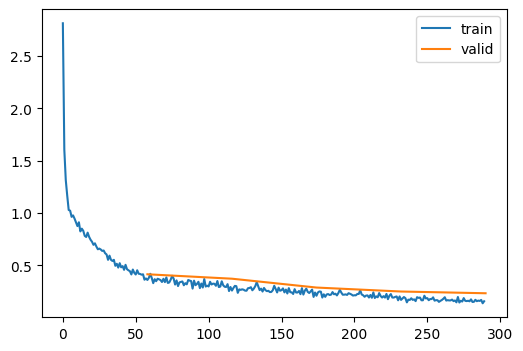

In [9]:
learn.fit(epochs)

# Skip connection

In [10]:
# export

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    conv2 = conv(nf,nf, stride=stride, act=None, norm=norm, ks=ks)
    if norm: init.constant_(conv2[1].weight, 0.)
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks), conv2)

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [11]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1,8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
try:
    with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)
except:
    pass

ResBlock torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 28, 28])
ResBlock torch.Size([1024, 8, 28, 28]) torch.Size([1024, 16, 14, 14])
ResBlock torch.Size([1024, 16, 14, 14]) torch.Size([1024, 32, 7, 7])
ResBlock torch.Size([1024, 32, 7, 7]) torch.Size([1024, 64, 4, 4])
ResBlock torch.Size([1024, 64, 4, 4]) torch.Size([1024, 128, 2, 2])
ResBlock torch.Size([1024, 128, 2, 2]) torch.Size([1024, 256, 1, 1])
Flatten torch.Size([1024, 256, 1, 1]) torch.Size([1024, 256])
Linear torch.Size([1024, 256]) torch.Size([1024, 10])
BatchNorm1d torch.Size([1024, 10]) torch.Size([1024, 10])


In [16]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res, tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    try: 
        with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    except: pass
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else:
        print(res)

In [17]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1225380


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|656|
|ResBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3584|
|ResBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14336|
|ResBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|57344|
|ResBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|229376|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|917504|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2560|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|


In [24]:
m = get_model()

In [25]:
[o.shape for o in m.parameters()]

[torch.Size([8, 1, 3, 3]),
 torch.Size([8, 8, 3, 3]),
 torch.Size([8, 1, 1, 1]),
 torch.Size([16, 8, 3, 3]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16, 8, 1, 1]),
 torch.Size([32, 16, 3, 3]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32, 16, 1, 1]),
 torch.Size([64, 32, 3, 3]),
 torch.Size([64, 64, 3, 3]),
 torch.Size([64, 32, 1, 1]),
 torch.Size([128, 64, 3, 3]),
 torch.Size([128, 128, 3, 3]),
 torch.Size([128, 64, 1, 1]),
 torch.Size([256, 128, 3, 3]),
 torch.Size([256, 256, 3, 3]),
 torch.Size([256, 128, 1, 1]),
 torch.Size([10, 256]),
 torch.Size([10]),
 torch.Size([10])]

In [ ]:
#export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

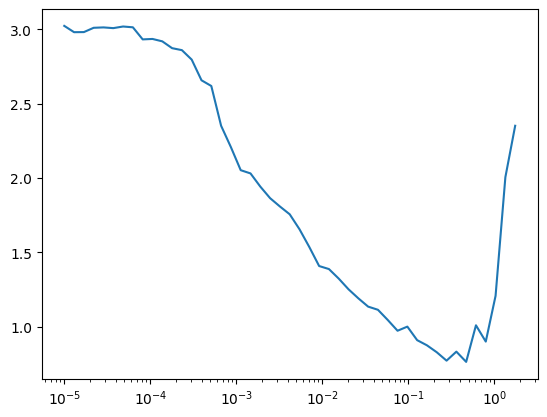

In [26]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
try: 
    MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()
except: pass

In [30]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.800,0.752,0,True
0.847,0.472,0,False
0.882,0.385,1,True
0.885,0.339,1,False
0.908,0.279,2,True
0.909,0.272,2,False
0.929,0.210,3,True
0.922,0.246,3,False
0.949,0.158,4,True
0.923,0.226,4,False


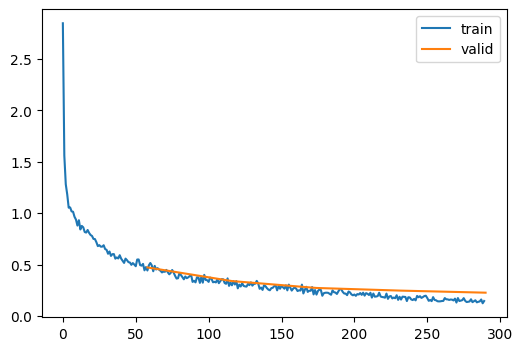

In [31]:
learn.fit(epochs)

In [32]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [33]:
" ".join(timm.list_models("*resnet*"))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight gcresnet33ts gcresnet50t inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet10t resnet14t resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_clip resnet50_clip_gap resnet50_gn resnet50_mlp resnet50c resnet50d resnet50s resnet50t resnet50x4_clip resnet50x4_clip_gap resnet50x16_clip resnet50x16_clip_gap resnet50x64_clip resnet50x64_clip_gap resnet51q resnet61q resnet101 resnet101_clip resnet101_clip_gap resnet101c resnet101d resnet101s resnet152 resnet152c resnet152d resnet152s resnet200 resnet200d 

In [38]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10).to('cuda:0')

In [39]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.777,0.641,0,True
0.627,1.884,0,False
0.879,0.326,1,True
0.842,0.465,1,False
0.910,0.246,2,True
0.899,0.280,2,False
0.929,0.190,3,True
0.911,0.247,3,False
0.947,0.145,4,True
0.921,0.224,4,False


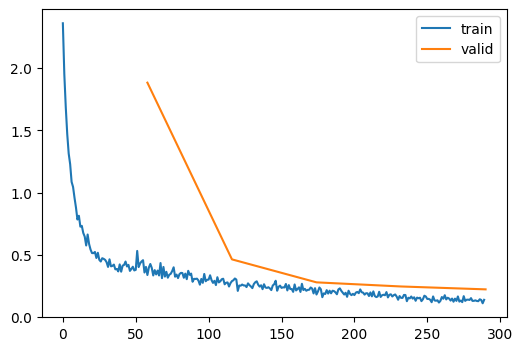

In [40]:
learn.fit(epochs)